In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col, count, avg, stddev, min as _min, max as _max

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Initialize Spark
spark = pyspark.sql.SparkSession.builder \
    .appName("explore_silver") \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/07 06:44:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Configuration
SILVER_DIR = "/app/datamart/silver/"
SNAPSHOT_DATE = "2023-01-01"  # Choose a snapshot date to explore

## EXPLORING LOAN DAILY TABLE

In [5]:
# Load loan data
loan_df = spark.read.parquet(os.path.join(SILVER_DIR, "loan_daily", "*.parquet"))
#loan_df = loan_df.filter(col("snapshot_date") <= SNAPSHOT_DATE)

In [6]:
print(f"\nTotal records: {loan_df.count():,}")

[Stage 1:=======>                                                   (1 + 7) / 8]


Total records: 104,288


In [7]:
print(f"Unique loans: {loan_df.select('loan_id').distinct().count():,}")

[Stage 4:=======>                                                   (1 + 7) / 8]

Unique loans: 11,974


In [8]:
print(f"Unique customers: {loan_df.select('Customer_ID').distinct().count():,}")

[Stage 10:=============================>                            (4 + 4) / 8]

Unique customers: 11,974


In [9]:
# Convert to pandas for easier exploration
loan_sample = loan_df.limit(50000).toPandas()

In [10]:
loan_df.printSchema()

root
 |-- loan_id: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- loan_start_date: date (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- installment_num: integer (nullable = true)
 |-- loan_amt: integer (nullable = true)
 |-- due_amt: double (nullable = true)
 |-- paid_amt: double (nullable = true)
 |-- overdue_amt: double (nullable = true)
 |-- balance: double (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- mob: integer (nullable = true)
 |-- installments_missed: integer (nullable = true)
 |-- first_missed_date: date (nullable = true)
 |-- dpd: integer (nullable = true)
 |-- asof_date: date (nullable = true)



In [11]:
# Basic Statistics
loan_sample[['loan_amt', 'tenure', 'due_amt', 'paid_amt', 'overdue_amt', 
                   'balance', 'mob', 'dpd']].describe()

,loan_amt,tenure,due_amt,paid_amt,overdue_amt,balance,mob,dpd
count,50000.0,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,10000.0,10.0,908.320000,710.680000,867.020000,5877.480000,4.989540,26.445960
std,0.0,0.0,288.576581,487.338371,1995.869733,3079.886128,3.171793,60.888995
min,10000.0,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10000.0,10.0,1000.000000,0.000000,0.000000,3000.000000,2.000000,0.000000
50%,10000.0,10.0,1000.000000,1000.000000,0.000000,7000.000000,5.000000,0.000000
75%,10000.0,10.0,1000.000000,1000.000000,0.000000,8000.000000,8.000000,0.000000
max,10000.0,10.0,1000.000000,4000.000000,10000.000000,10000.000000,10.000000,306.000000


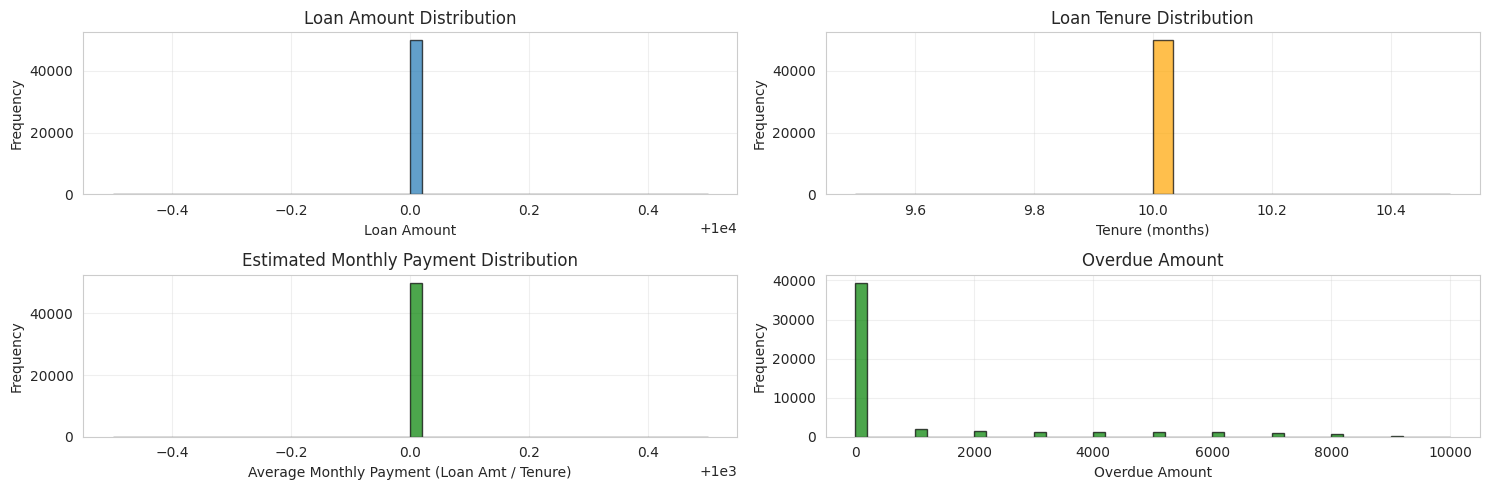

In [12]:
# Loan amount distribution
plt.figure(figsize=(15, 5))

plt.subplot(2, 2, 1)
plt.hist(loan_sample['loan_amt'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Loan Amount Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.hist(loan_sample['tenure'], bins=30, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Tenure (months)')
plt.ylabel('Frequency')
plt.title('Loan Tenure Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.hist(loan_sample['loan_amt']/loan_sample['tenure'], bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Average Monthly Payment (Loan Amt / Tenure)')
plt.ylabel('Frequency')
plt.title('Estimated Monthly Payment Distribution')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.hist(loan_sample['overdue_amt'], bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Overdue Amount')
plt.ylabel('Frequency')
plt.title('Overdue Amount')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('loan_distributions.png', dpi=150, bbox_inches='tight')
plt.close()
print("\n✓ Saved: loan_distributions.png")

### DPD (Days Past Due) Analysis - KEY FOR DEFAULT PREDICTION

In [13]:
# DPD (Days Past Due) Analysis - KEY FOR DEFAULT PREDICTION
dpd_stats = loan_sample.groupby('dpd').size().reset_index(name='count')
dpd_stats = dpd_stats.sort_values('dpd')
dpd_stats.head(20)

,dpd,count
0,0,39463
1,29,213
2,30,670
3,31,1043
4,60,314
5,61,814
6,62,301
7,90,144
8,91,454
9,92,705


In [14]:
# DPD thresholds
dpd_0 = (loan_sample['dpd'] == 0).sum()
dpd_30_plus = (loan_sample['dpd'] >= 30).sum()
dpd_60_plus = (loan_sample['dpd'] >= 60).sum()
dpd_90_plus = (loan_sample['dpd'] >= 90).sum()

print(f"\nDPD = 0 (current): {dpd_0:,} ({dpd_0/len(loan_sample)*100:.1f}%)")
print(f"DPD >= 30: {dpd_30_plus:,} ({dpd_30_plus/len(loan_sample)*100:.1f}%)")
print(f"DPD >= 60: {dpd_60_plus:,} ({dpd_60_plus/len(loan_sample)*100:.1f}%)")
print(f"DPD >= 90: {dpd_90_plus:,} ({dpd_90_plus/len(loan_sample)*100:.1f}%)")


DPD = 0 (current): 39,463 (78.9%)
DPD >= 30: 10,324 (20.6%)
DPD >= 60: 8,611 (17.2%)
DPD >= 90: 7,182 (14.4%)


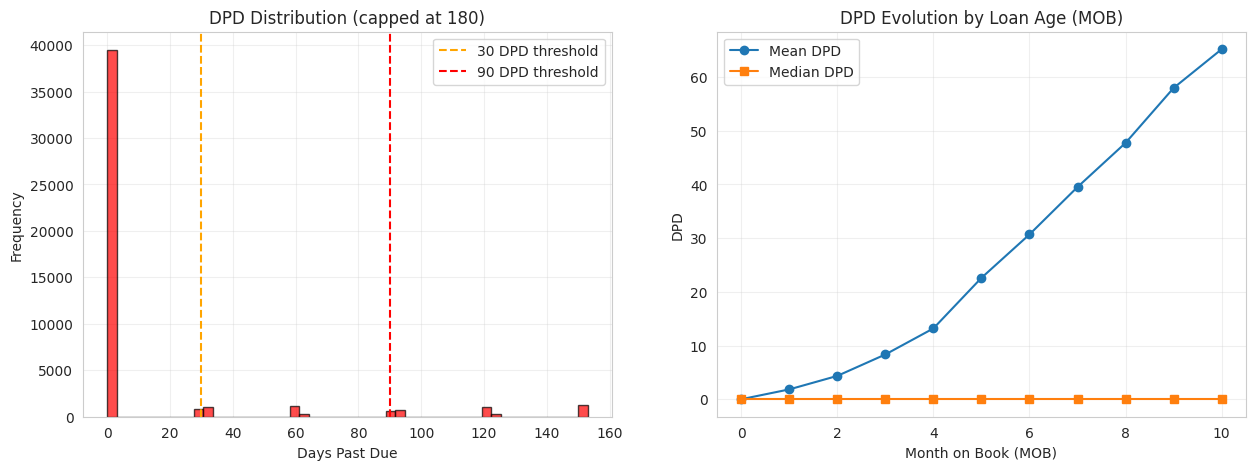

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
dpd_plot = loan_sample[loan_sample['dpd'] <= 180]['dpd']
plt.hist(dpd_plot, bins=50, edgecolor='black', alpha=0.7, color='red')
plt.xlabel('Days Past Due')
plt.ylabel('Frequency')
plt.title('DPD Distribution (capped at 180)')
plt.axvline(x=30, color='orange', linestyle='--', label='30 DPD threshold')
plt.axvline(x=90, color='red', linestyle='--', label='90 DPD threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
mob_dpd = loan_sample.groupby('mob')['dpd'].agg(['mean', 'median', 'count']).reset_index()
plt.plot(mob_dpd['mob'], mob_dpd['mean'], marker='o', label='Mean DPD')
plt.plot(mob_dpd['mob'], mob_dpd['median'], marker='s', label='Median DPD')
plt.xlabel('Month on Book (MOB)')
plt.ylabel('DPD')
plt.title('DPD Evolution by Loan Age (MOB)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dpd_analysis.png', dpi=150, bbox_inches='tight')
plt.close()
print("✓ Saved: dpd_analysis.png")

### MOB (Month on Book) Analysis

In [16]:
mob_stats = loan_sample.groupby('mob').agg({
    'loan_id': 'count',
    'overdue_amt': 'mean',
    'balance': 'mean',
    'dpd': lambda x: (x > 0).sum()
}).round(2)
mob_stats.columns = ['loan_count', 'avg_overdue', 'avg_balance', 'loans_with_dpd']
mob_stats.head(12)

,loan_count,avg_overdue,avg_balance,loans_with_dpd
mob,,,,
0,4584,0.00,10000.00,0
1,4616,60.23,9060.23,278
2,4579,142.61,8142.61,546
3,4545,273.71,7273.71,853
4,4518,432.93,6432.93,1052
5,4491,741.48,5741.48,1315
6,4506,1006.21,5006.21,1297
7,4503,1295.36,4295.36,1295
8,4520,1564.82,3564.82,1277


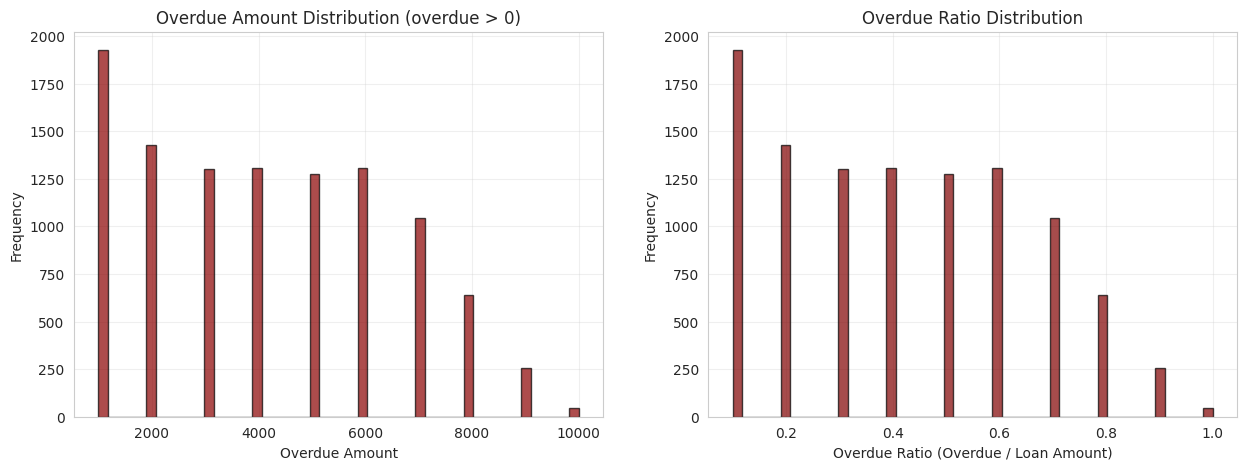

In [17]:
# Overdue amount analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
overdue_positive = loan_sample[loan_sample['overdue_amt'] > 0]['overdue_amt']
if len(overdue_positive) > 0:
    plt.hist(overdue_positive, bins=50, edgecolor='black', alpha=0.7, color='darkred')
    plt.xlabel('Overdue Amount')
    plt.ylabel('Frequency')
    plt.title('Overdue Amount Distribution (overdue > 0)')
    plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
loan_sample['overdue_ratio'] = loan_sample['overdue_amt'] / loan_sample['loan_amt']
overdue_ratio_positive = loan_sample[loan_sample['overdue_ratio'] > 0]['overdue_ratio']
if len(overdue_ratio_positive) > 0:
    plt.hist(overdue_ratio_positive.clip(upper=1), bins=50, edgecolor='black', alpha=0.7, color='maroon')
    plt.xlabel('Overdue Ratio (Overdue / Loan Amount)')
    plt.ylabel('Frequency')
    plt.title('Overdue Ratio Distribution')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('overdue_analysis.png', dpi=150, bbox_inches='tight')
plt.close()

#### INSIGHTS FROM LOAN DATA
- DPD (Days Past Due) is the KEY indicator for default
- Consider DPD >= 30 as default threshold (common in industry)
- MOB (Month on Book) shows loan maturity - early defaults are risky
- Overdue amount and ratio indicate repayment behavior

## FINANCIAL FEATURES EXPLORATION

In [95]:
fin_df = spark.read.parquet(os.path.join(SILVER_DIR, "features_financials", "*.parquet"))
#fin_df = fin_df.filter(col("snapshot_date") <= SNAPSHOT_DATE)

In [96]:
window_spec = Window.partitionBy("Customer_ID").orderBy(col("snapshot_date").desc())
fin_latest = fin_df.withColumn("row_num", F.row_number().over(window_spec)) \
                   .filter(col("row_num") == 1) \
                   .drop("row_num")

In [97]:
print(f"\nTotal customer snapshots: {fin_df.count():,}")
print(f"Unique customers: {fin_latest.count():,}")


Total customer snapshots: 11,974
Unique customers: 11,974


Only the latest snapshot is retained in the features_financial table!

In [104]:
fin_df.filter(col("Customer_ID") == "CUS_0x10ac").show()

+-----------+---------------------+-----------------+---------------+-------------+--------------------+-------------------+--------------------+----------+------------------------+--------------------+---------------------+-------------------+-----------------+-----------------+-------------+-------------+-----------+----------------------+--------------------+----------------+-----------------------+-----------------------+------------------------+-------------------+-------------------+-------------------------+-----------------------+---------------------+-------------------+----------------------+----------------------------+---------------+----------+
|Customer_ID|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|        Type_of_Loan|Delay_from_due_date|Num_Credit_Inquiries|Credit_Mix|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Payment_Behaviour|  Monthly_Balance|snapshot_date|Annual_Income|Num_of_Loan|Num_of_Delayed

In [98]:
customer_history = fin_df.groupBy("Customer_ID").count().filter(col("count") > 5)

print("customers with >5 snapshots:", customer_history.count())
print("some IDs:", customer_history.select("Customer_ID").limit(5).collect())


customers with >5 snapshots: 0
some IDs: []


In [100]:
fin_df.show(5)

+-----------+---------------------+-----------------+---------------+-------------+--------------------+-------------------+--------------------+----------+------------------------+--------------------+---------------------+-------------------+--------------------+------------------+-------------+-------------+-----------+----------------------+--------------------+----------------+-----------------------+-----------------------+------------------------+--------------------+-------------------+-------------------------+-----------------------+---------------------+-------------------+----------------------+----------------------------+---------------+----------+
|Customer_ID|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|        Type_of_Loan|Delay_from_due_date|Num_Credit_Inquiries|Credit_Mix|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|   Payment_Behaviour|   Monthly_Balance|snapshot_date|Annual_Income|Num_of_Loan|Num_o

In [28]:
# Financial Statistics
fin_sample = fin_latest.limit(50000).toPandas()
fin_sample[['Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                  'Num_Credit_Card', 'Num_of_Loan', 'Num_of_Delayed_Payment',
                  'Outstanding_Debt', 'Credit_History_Age']].describe()

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Num_of_Delayed_Payment,Outstanding_Debt
count,5.300000e+02,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000
mean,1.244281e+05,4206.805653,14.554717,15.147170,0.250943,30.464151,1355.046604
std,9.730980e+05,3067.671216,101.879659,82.213224,40.941233,224.207674,1118.023577
min,7.110930e+03,368.374167,0.000000,1.000000,-100.000000,-2.000000,1.370000
25%,1.957517e+04,1610.690971,4.000000,4.000000,1.000000,9.000000,544.387500
50%,4.022940e+04,3315.590000,6.000000,5.000000,3.000000,14.000000,1080.050000
75%,7.053660e+04,5728.096667,7.000000,7.000000,5.000000,18.000000,1806.435000
max,1.770615e+07,14601.520000,1605.000000,896.000000,777.000000,4106.000000,4980.310000


### Income analysis

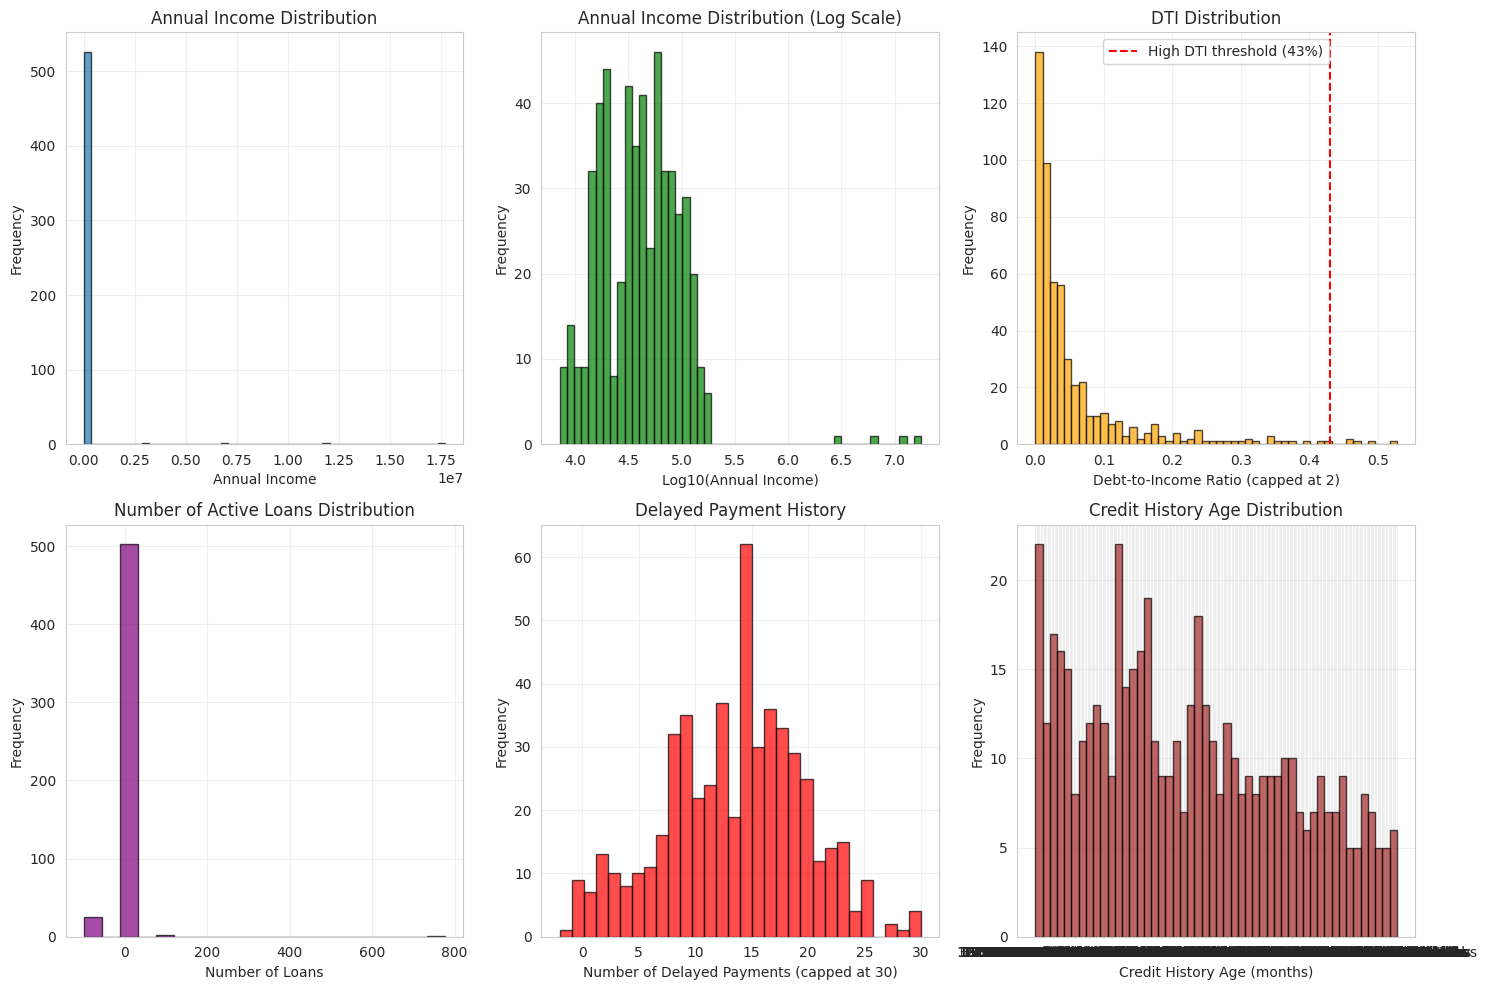

In [29]:
# Income analysis
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(fin_sample['Annual_Income'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.title('Annual Income Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.hist(np.log10(fin_sample['Annual_Income'] + 1), bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Log10(Annual Income)')
plt.ylabel('Frequency')
plt.title('Annual Income Distribution (Log Scale)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
fin_sample['DTI'] = fin_sample['Outstanding_Debt'] / fin_sample['Annual_Income']
plt.hist(fin_sample['DTI'].clip(upper=2), bins=50, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Debt-to-Income Ratio (capped at 2)')
plt.ylabel('Frequency')
plt.title('DTI Distribution')
plt.axvline(x=0.43, color='red', linestyle='--', label='High DTI threshold (43%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
plt.hist(fin_sample['Num_of_Loan'], bins=20, edgecolor='black', alpha=0.7, color='purple')
plt.xlabel('Number of Loans')
plt.ylabel('Frequency')
plt.title('Number of Active Loans Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
plt.hist(fin_sample['Num_of_Delayed_Payment'].clip(upper=30), bins=30, edgecolor='black', alpha=0.7, color='red')
plt.xlabel('Number of Delayed Payments (capped at 30)')
plt.ylabel('Frequency')
plt.title('Delayed Payment History')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
plt.hist(fin_sample['Credit_History_Age'], bins=50, edgecolor='black', alpha=0.7, color='brown')
plt.xlabel('Credit History Age (months)')
plt.ylabel('Frequency')
plt.title('Credit History Age Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.savefig('financial_distributions.png', dpi=150, bbox_inches='tight')
plt.close()
print("\n✓ Saved: financial_distributions.png")

### DTI Analysis (Critical for lending)

In [30]:
fin_sample['DTI'] = fin_sample['Outstanding_Debt'] / fin_sample['Annual_Income']

In [31]:
dti_stats = fin_sample['DTI'].describe()
dti_stats

count    530.000000
mean       0.055911
std        0.083106
min        0.000018
25%        0.009922
50%        0.025709
75%        0.061669
max        0.528041
Name: DTI, dtype: float64

In [32]:
dti_ranges = pd.cut(fin_sample['DTI'], bins=[0, 0.2, 0.36, 0.43, 1.0, 10.0],
                    labels=['Very Low (<20%)', 'Low (20-36%)', 'Moderate (36-43%)', 
                           'High (43-100%)', 'Very High (>100%)'])
print("\nDTI Distribution:")
dti_ranges.value_counts().sort_index()


DTI Distribution:


DTI
Very Low (<20%)      495
Low (20-36%)          26
Moderate (36-43%)      4
High (43-100%)         5
Very High (>100%)      0
Name: count, dtype: int64

### Credit utilization

In [34]:
fin_sample['Credit_Utilization'] = fin_sample['Outstanding_Debt'] / fin_sample['Total_EMI_per_month']
fin_sample['Credit_Utilization'].describe()

/usr/local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    530.000000
mean            inf
std             NaN
min        0.001047
25%        5.743144
50%       16.691683
75%       51.251404
max             inf
Name: Credit_Utilization, dtype: float64

### Payment behavior

In [35]:
fin_sample['Payment_Behaviour'].value_counts()

Payment_Behaviour
Low_spent_Small_value_payments      144
High_spent_Medium_value_payments    106
High_spent_Large_value_payments      77
Low_spent_Medium_value_payments      71
High_spent_Small_value_payments      49
Low_spent_Large_value_payments       45
Unknown                              38
Name: count, dtype: int64

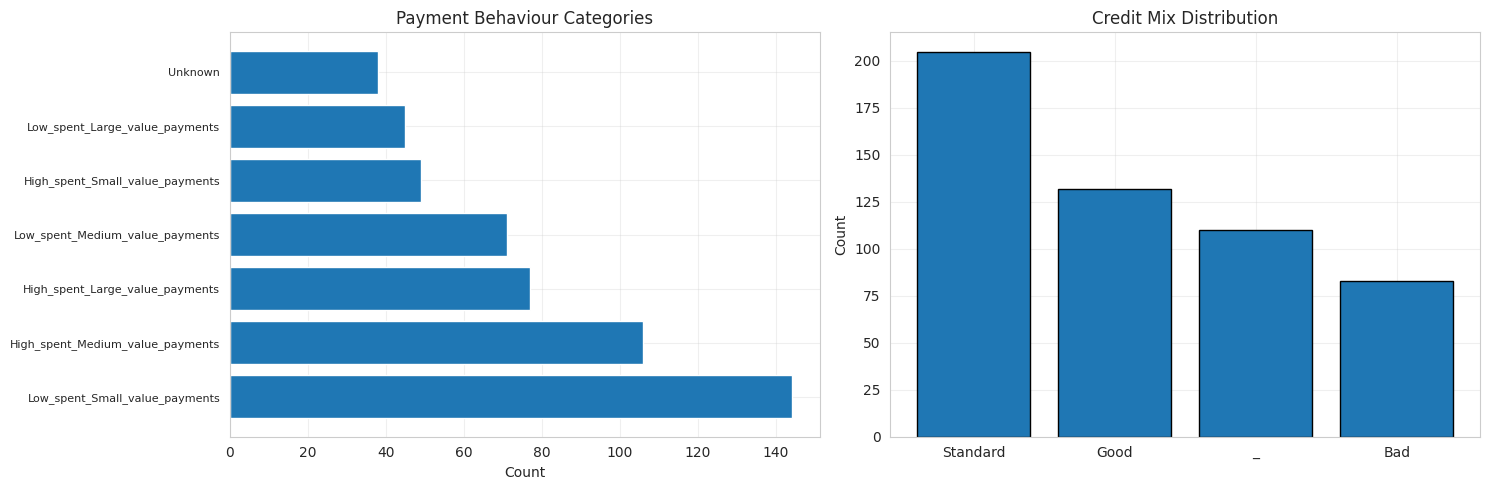

In [36]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
payment_counts = fin_sample['Payment_Behaviour'].value_counts()
plt.barh(range(len(payment_counts)), payment_counts.values)
plt.yticks(range(len(payment_counts)), payment_counts.index, fontsize=8)
plt.xlabel('Count')
plt.title('Payment Behaviour Categories')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
credit_mix_counts = fin_sample['Credit_Mix'].value_counts()
plt.bar(range(len(credit_mix_counts)), credit_mix_counts.values, edgecolor='black')
plt.xticks(range(len(credit_mix_counts)), credit_mix_counts.index)
plt.ylabel('Count')
plt.title('Credit Mix Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.savefig('behavioral_features.png', dpi=150, bbox_inches='tight')
plt.close()
print("✓ Saved: behavioral_features.png")

#### INSIGHTS FROM FINANCIAL DATA
- DTI (Debt-to-Income) ratio is CRITICAL - lenders typically reject DTI > 43%
- Number of delayed payments indicates credit risk
- Credit history age shows experience with credit (longer = better)
- Payment behaviour patterns reveal spending habits
- Credit Mix (Good/Standard/Bad) is a strong signal

## ATTRIBUTES EXPLORATION

In [149]:
attr_df = spark.read.parquet(os.path.join(SILVER_DIR, "features_attributes", "*.parquet"))
#attr_df = attr_df.filter(col("snapshot_date") <= SNAPSHOT_DATE)

In [159]:
attr_sample = attr_df.limit(50000).toPandas()

In [150]:
print(f"\nUnique customers: {attr_df.count():,}")


Unique customers: 11,974


In [151]:
attr_df.printSchema()

root
 |-- Customer_ID: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- Age: integer (nullable = true)
 |-- age_clean: integer (nullable = true)
 |-- asof_date: date (nullable = true)



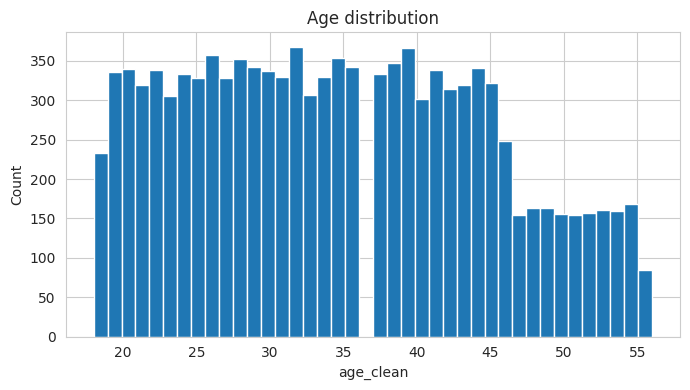

In [156]:
# Pull just the non-null ages to the driver (OK if it's not huge)
ages_pdf = (attr_df
            .select('age_clean')
            .where(col('age_clean').isNotNull())
            .toPandas())

plt.figure(figsize=(7,4))
plt.hist(ages_pdf['age_clean'], bins=40)   # adjust bins if you like
plt.xlabel('age_clean')
plt.ylabel('Count')
plt.title('Age distribution')
plt.tight_layout()
plt.show()


In [157]:
ages_pdf.describe()

,age_clean
count,11039.000000
mean,34.662560
std,10.144856
min,18.000000
25%,26.000000
50%,34.000000
75%,42.000000
max,56.000000


In [127]:
prof = (attr_df
  .withColumn("unit_bucket",
      F.when(F.col("Age").isNull(), "null")
       .when(F.col("Age") <= 0, "<=0")
       .when((F.col("Age") >= 18) & (F.col("Age") <= 100), "18-100_ok")
       .when( (F.col("Age") > 120) & ((F.col("Age")/365.25).between(15,100)), "looks_days")
       .when( (F.col("Age") > 120) & ((F.col("Age")/12).between(15,100)),     "looks_months")
       .when(F.col("Age") > 120, ">120_other")
       .otherwise("other"))
  .groupBy("unit_bucket").count()
  .orderBy(F.desc("count"))
)
prof.show(truncate=False)


+------------+-----+
|unit_bucket |count|
+------------+-----+
|18-100_ok   |11039|
|other       |631  |
|<=0         |99   |
|>120_other  |98   |
|looks_days  |81   |
|looks_months|26   |
+------------+-----+



In [147]:
age = F.col("Age").cast("double")
# looks_days   = (age > 120) & ( (age/365.25).between(15,100) )
# looks_months = (age > 120) & ( (age/12.0).between(15,100) )

age_years = (
    F.when((age >= 18) & (age <= 100), age)
     # .when(looks_days,   F.round(age/365.25, 0))
     # .when(looks_months, F.round(age/12.0,   0))
     .otherwise(F.lit(None).cast("double"))
)

attr_clean = (attr_df
  .withColumn("age_years", age_years)
  # .withColumn("age_from_days_flag",   F.when(looks_days,   1).otherwise(0))
  # .withColumn("age_from_months_flag", F.when(looks_months, 1).otherwise(0))
  .withColumn("age_invalid_flag",     F.when(F.col("age_years").isNull(), 1).otherwise(0))
)

In [148]:
(attr_clean
 .groupBy("age_years")
 .count()
 .orderBy(F.col("age_years").asc())
 .show(1000, truncate=False))

+---------+-----+
|age_years|count|
+---------+-----+
|NULL     |935  |
|18.0     |233  |
|19.0     |336  |
|20.0     |340  |
|21.0     |320  |
|22.0     |338  |
|23.0     |306  |
|24.0     |334  |
|25.0     |329  |
|26.0     |358  |
|27.0     |328  |
|28.0     |352  |
|29.0     |342  |
|30.0     |337  |
|31.0     |330  |
|32.0     |368  |
|33.0     |307  |
|34.0     |330  |
|35.0     |354  |
|36.0     |343  |
|37.0     |333  |
|38.0     |347  |
|39.0     |367  |
|40.0     |302  |
|41.0     |338  |
|42.0     |315  |
|43.0     |319  |
|44.0     |341  |
|45.0     |322  |
|46.0     |249  |
|47.0     |155  |
|48.0     |163  |
|49.0     |163  |
|50.0     |156  |
|51.0     |154  |
|52.0     |157  |
|53.0     |161  |
|54.0     |160  |
|55.0     |168  |
|56.0     |84   |
+---------+-----+



### Age and occupation analysis

In [42]:
attr_sample['Age'].describe()

count    11974.000000
mean       105.949223
std        666.659669
min       -500.000000
25%         25.000000
50%         33.000000
75%         42.000000
max       8678.000000
Name: Age, dtype: float64

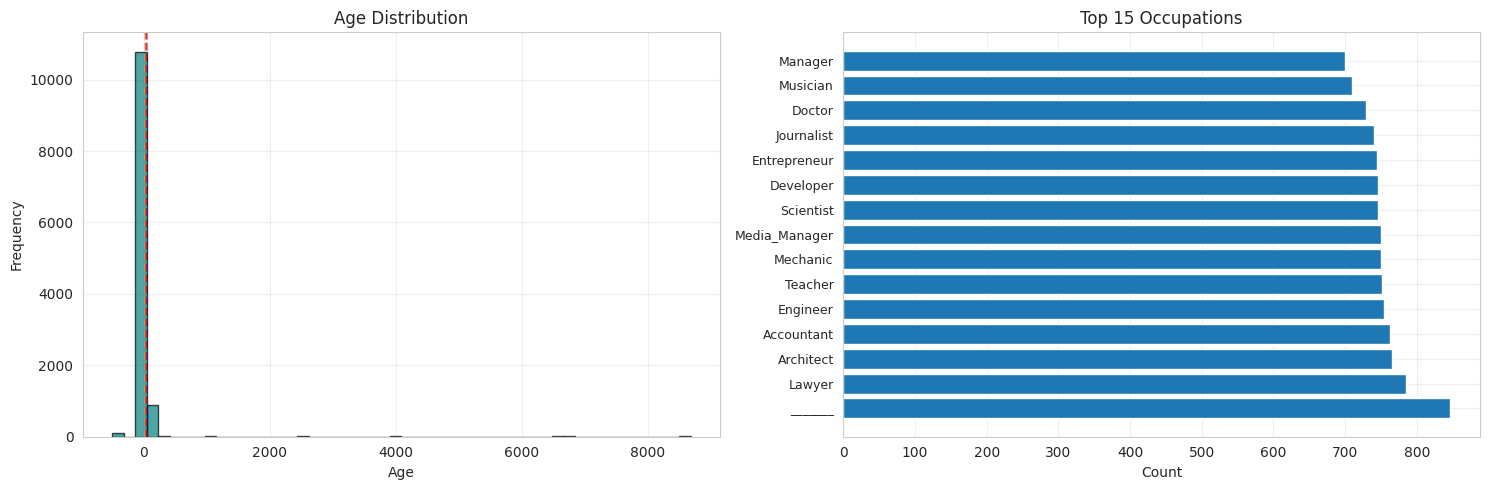

In [43]:
# Age and occupation analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(attr_sample['Age'], bins=50, edgecolor='black', alpha=0.7, color='teal')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.axvline(x=25, color='orange', linestyle='--', alpha=0.5)
plt.axvline(x=35, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=50, color='purple', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
occ_counts = attr_sample['Occupation'].value_counts().head(15)
plt.barh(range(len(occ_counts)), occ_counts.values)
plt.yticks(range(len(occ_counts)), occ_counts.index, fontsize=9)
plt.xlabel('Count')
plt.title('Top 15 Occupations')
plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.savefig('demographic_distributions.png', dpi=150, bbox_inches='tight')
plt.close()
print("\n✓ Saved: demographic_distributions.png")

In [160]:
# Age Bands
age_bands = pd.cut(attr_sample['age_clean'], bins=[0, 25, 35, 45, 55, 100],
                   labels=['18-25', '26-35', '36-45', '46-55', '56+'])
age_bands.value_counts().sort_index()

age_clean
18-25    2536
26-35    3406
36-45    3327
46-55    1686
56+        84
Name: count, dtype: int64

In [45]:
# Top Occupations
attr_sample['Occupation'].value_counts().head(15)

Occupation
_______          846
Lawyer           785
Architect        766
Accountant       763
Engineer         754
Teacher          751
Mechanic         750
Media_Manager    750
Scientist        746
Developer        746
Entrepreneur     744
Journalist       741
Doctor           729
Musician         709
Manager          700
Name: count, dtype: int64

#### INSIGHTS FROM ATTRIBUTES
- Age distribution shows typical working-age population
- Can create age bands for segmentation (young/mid/senior career)
- Occupation can be used for income stability proxy
- Consider one-hot encoding for categorical features

## CLICKSTREAM FEATURES EXPLORATION

In [60]:
click_df = spark.read.parquet(os.path.join(SILVER_DIR, "feature_clickstream", "*.parquet"))
click_df = click_df.filter(col("snapshot_date") == '2024-01-01')

In [61]:
print(f"\nTotal clickstream records: {click_df.count():,}")
print(f"Unique customers: {click_df.select('Customer_ID').distinct().count():,}")


Total clickstream records: 8,974
Unique customers: 8,974


In [62]:
click_sample = click_df.limit(50000).toPandas()

In [63]:
click_sample.head(20)

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date,asof_date
0,224,270,357,188,52,113,235,68,68,137,...,68,-13,-23,-21,119,173,119,CUS_0x1000,2024-01-01,2024-01-01
1,66,119,-2,70,38,369,2,39,161,159,...,175,84,410,218,-19,180,183,CUS_0x100b,2024-01-01,2024-01-01
2,1,113,167,296,14,290,40,119,75,217,...,55,261,163,-86,144,-34,29,CUS_0x1011,2024-01-01,2024-01-01
3,181,-95,183,48,62,176,174,76,-79,2,...,95,-54,140,325,200,50,189,CUS_0x1013,2024-01-01,2024-01-01
4,242,111,187,-5,40,99,15,245,273,-35,...,-9,-16,148,35,82,6,-38,CUS_0x1015,2024-01-01,2024-01-01
5,157,199,-23,108,198,54,152,180,96,35,...,132,61,-11,133,181,61,131,CUS_0x1018,2024-01-01,2024-01-01
6,-61,54,-161,172,76,204,-28,200,120,28,...,132,120,206,-13,333,84,-132,CUS_0x1026,2024-01-01,2024-01-01
7,271,66,2,226,30,86,86,-5,-22,-16,...,162,209,-104,-54,72,104,-47,CUS_0x102d,2024-01-01,2024-01-01
8,-98,145,68,86,-19,163,103,-62,159,97,...,80,241,196,177,183,300,-7,CUS_0x102e,2024-01-01,2024-01-01
9,155,192,230,35,130,71,-37,79,250,86,...,378,36,174,270,75,154,103,CUS_0x1032,2024-01-01,2024-01-01


In [64]:
click_df.printSchema()

root
 |-- fe_1: integer (nullable = true)
 |-- fe_2: integer (nullable = true)
 |-- fe_3: integer (nullable = true)
 |-- fe_4: integer (nullable = true)
 |-- fe_5: integer (nullable = true)
 |-- fe_6: integer (nullable = true)
 |-- fe_7: integer (nullable = true)
 |-- fe_8: integer (nullable = true)
 |-- fe_9: integer (nullable = true)
 |-- fe_10: integer (nullable = true)
 |-- fe_11: integer (nullable = true)
 |-- fe_12: integer (nullable = true)
 |-- fe_13: integer (nullable = true)
 |-- fe_14: integer (nullable = true)
 |-- fe_15: integer (nullable = true)
 |-- fe_16: integer (nullable = true)
 |-- fe_17: integer (nullable = true)
 |-- fe_18: integer (nullable = true)
 |-- fe_19: integer (nullable = true)
 |-- fe_20: integer (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- asof_date: date (nullable = true)



In [65]:
# Analyze fe_1 to fe_20
fe_columns = [f'fe_{i}' for i in range(1, 21)]
print("\n--- Clickstream Feature Statistics ---")
click_sample[fe_columns].describe()


--- Clickstream Feature Statistics ---


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,fe_11,fe_12,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20
count,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000
mean,102.227992,103.645309,105.837419,105.089481,105.396256,104.055382,105.485179,109.800089,115.871741,118.593938,98.519724,98.452307,100.196345,100.453198,98.034099,97.857477,102.553822,99.519389,99.815913,99.045799
std,100.523098,99.307917,101.273135,100.129606,100.928798,101.133197,100.411781,99.984852,100.971977,101.129984,100.220786,99.137030,100.086124,100.805965,101.727208,100.671885,100.636513,101.539398,102.731244,102.539625
min,-283.000000,-266.000000,-259.000000,-236.000000,-320.000000,-237.000000,-282.000000,-294.000000,-260.000000,-290.000000,-291.000000,-321.000000,-302.000000,-242.000000,-320.000000,-263.000000,-329.000000,-261.000000,-332.000000,-346.000000
25%,35.000000,36.000000,37.000000,36.000000,37.000000,34.000000,37.000000,42.000000,46.250000,50.000000,31.000000,32.000000,33.000000,32.000000,30.000000,30.000000,33.000000,31.000000,31.000000,31.000000
50%,102.000000,103.000000,105.000000,105.000000,106.000000,102.000000,106.000000,110.000000,116.000000,119.000000,99.000000,98.000000,101.000000,100.000000,99.000000,99.000000,103.000000,100.000000,100.000000,100.000000
75%,170.000000,170.000000,175.000000,171.000000,174.000000,172.000000,172.000000,176.000000,186.000000,186.750000,165.000000,165.000000,169.000000,166.000000,166.000000,166.000000,171.000000,166.000000,168.000000,169.000000
max,489.000000,484.000000,454.000000,474.000000,491.000000,495.000000,485.000000,497.000000,471.000000,489.000000,613.000000,522.000000,464.000000,462.000000,486.000000,497.000000,485.000000,478.000000,523.000000,473.000000


### Correlation analysis

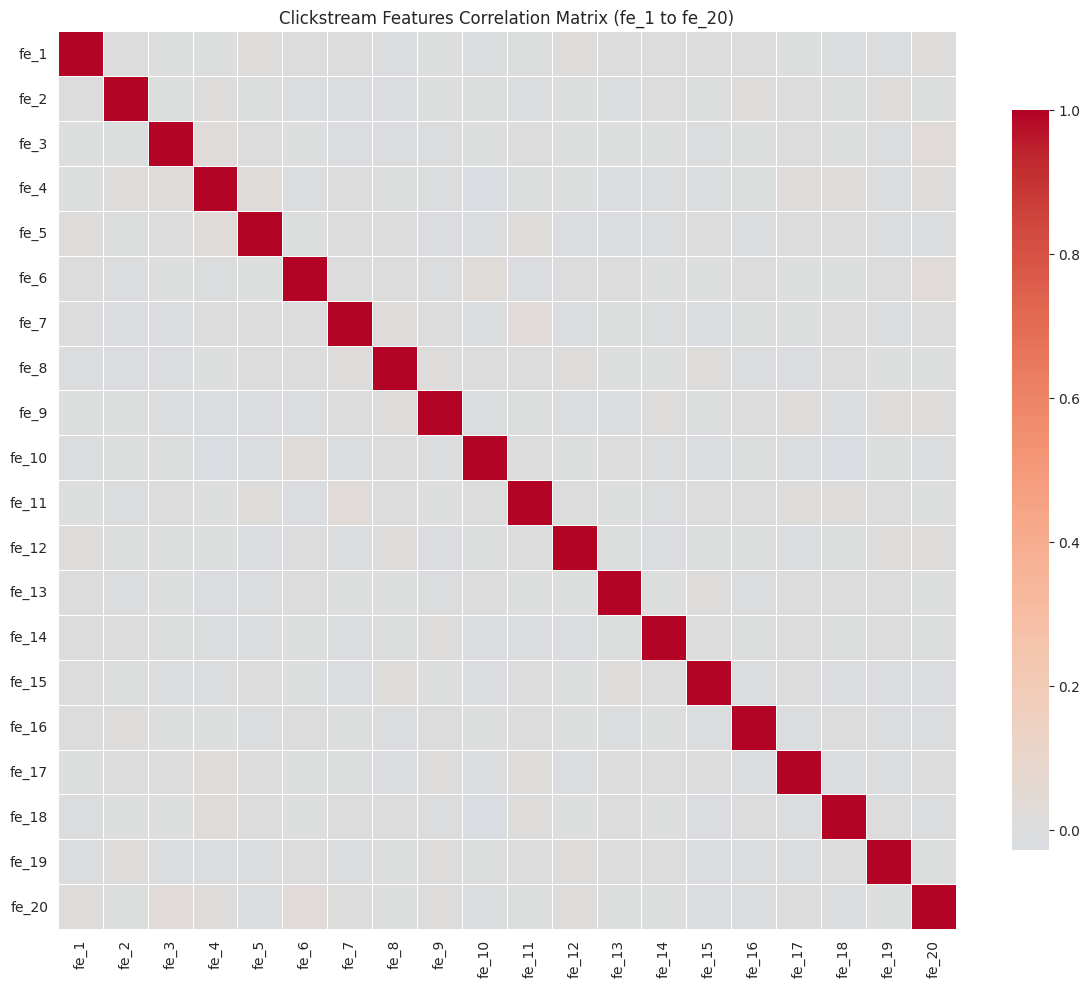

In [66]:
# Correlation analysis
correlation_matrix = click_sample[fe_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Clickstream Features Correlation Matrix (fe_1 to fe_20)')
plt.tight_layout()

plt.savefig('clickstream_correlation.png', dpi=150, bbox_inches='tight')
plt.close()
print("\n✓ Saved: clickstream_correlation.png")

### Activity over time

In [67]:
click_sample['total_activity'] = click_sample[fe_columns].sum(axis=1)

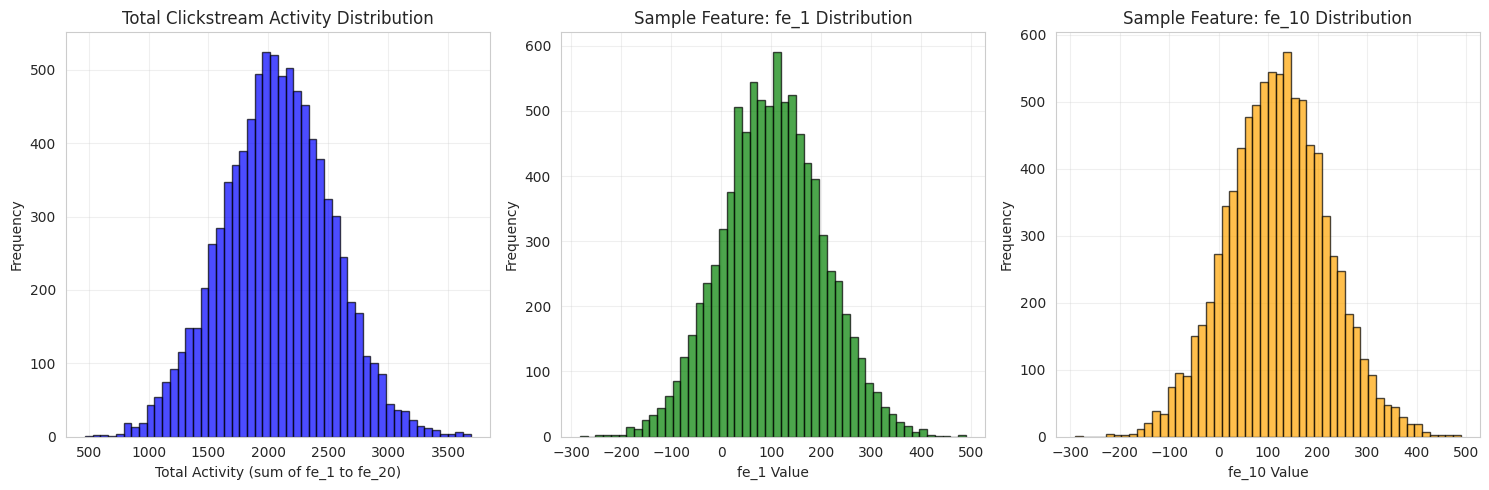

In [68]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(click_sample['total_activity'], bins=50, edgecolor='black', alpha=0.7, color='blue')
plt.xlabel('Total Activity (sum of fe_1 to fe_20)')
plt.ylabel('Frequency')
plt.title('Total Clickstream Activity Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(click_sample['fe_1'], bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('fe_1 Value')
plt.ylabel('Frequency')
plt.title('Sample Feature: fe_1 Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(click_sample['fe_10'], bins=50, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('fe_10 Value')
plt.ylabel('Frequency')
plt.title('Sample Feature: fe_10 Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.savefig('clickstream_distributions.png', dpi=150, bbox_inches='tight')
plt.close()
print("✓ Saved: clickstream_distributions.png")

#### INSIGHTS FROM CLICKSTREAM DATA
- 20 behavioral features (fe_1 to fe_20) capture user interactions
- Can aggregate over time windows (7d, 30d) to capture recent behavior
- Sum, mean, std of features show activity patterns
- Consider recency features (time since last activity)

## CROSS-TABLE ANALYSIS

### Joining Loan and Financial Data

In [71]:
# Get first loan record per customer (application time)
loan_first = loan_df.withColumn("row_num", F.row_number().over(
    Window.partitionBy("loan_id").orderBy("snapshot_date")
)).filter(col("row_num") == 1).drop("row_num")

# Join with financial data
joined_df = loan_first.alias("l").join(
    fin_latest.alias("f"),
    col("l.Customer_ID") == col("f.Customer_ID"),
    "inner"
).select(
    col("l.loan_id"),
    col("l.Customer_ID"),
    col("l.loan_amt"),
    col("l.tenure"),
    col("f.Annual_Income"),
    col("f.Outstanding_Debt"),
    col("f.Num_of_Loan"),
    col("f.Num_of_Delayed_Payment"),
    col("f.Credit_History_Age"),
    col("f.Credit_Mix")
)

joined_sample = joined_df.limit(10000).toPandas()

In [72]:
# Calculate DTI
joined_sample['DTI'] = joined_sample['Outstanding_Debt'] / joined_sample['Annual_Income']
joined_sample['Loan_to_Income'] = joined_sample['loan_amt'] / joined_sample['Annual_Income']

print("\n--- Joined Data Statistics ---")
joined_sample[['loan_amt', 'Annual_Income', 'DTI', 'Loan_to_Income', 
                     'Num_of_Delayed_Payment']].describe()


--- Joined Data Statistics ---


,loan_amt,Annual_Income,DTI,Loan_to_Income,Num_of_Delayed_Payment
count,530.0,5.300000e+02,530.000000,530.000000,530.000000
mean,10000.0,1.244281e+05,0.055911,0.348009,30.464151
std,0.0,9.730980e+05,0.083106,0.284724,224.207674
min,10000.0,7.110930e+03,0.000018,0.000565,-2.000000
25%,10000.0,1.957517e+04,0.009922,0.141770,9.000000
50%,10000.0,4.022940e+04,0.025709,0.248576,14.000000
75%,10000.0,7.053660e+04,0.061669,0.510852,18.000000
max,10000.0,1.770615e+07,0.528041,1.406286,4106.000000


/tmp/ipykernel_19270/1494203154.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delayed_loan = joined_sample.groupby(pd.cut(joined_sample['Num_of_Delayed_Payment'],


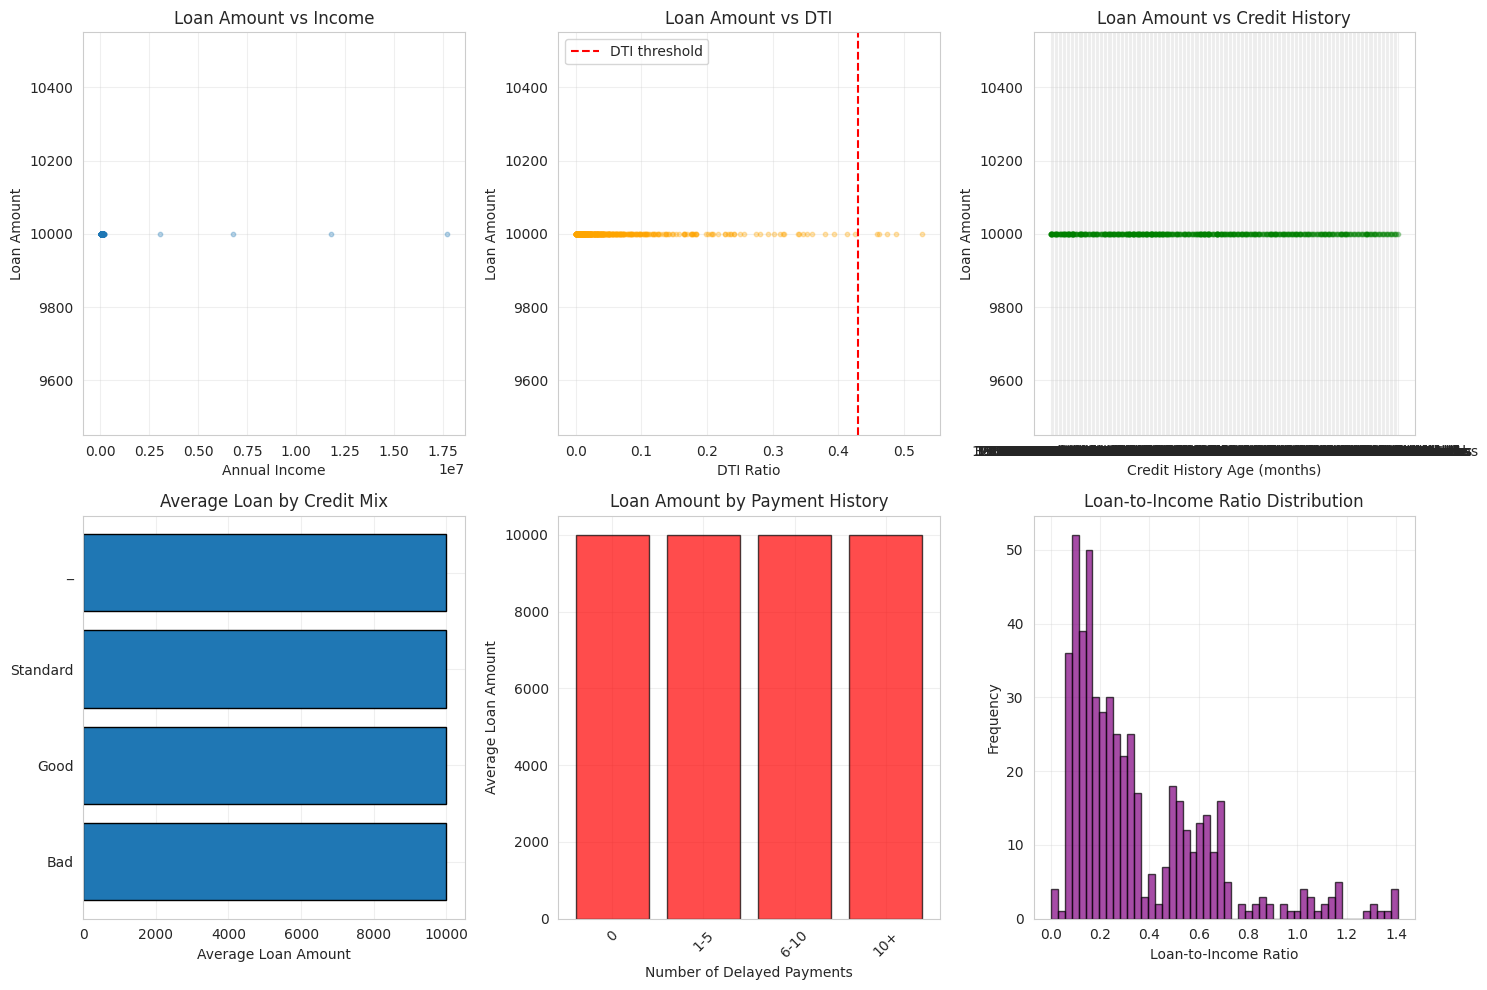

In [73]:
# Visualize relationships
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.scatter(joined_sample['Annual_Income'], joined_sample['loan_amt'], alpha=0.3, s=10)
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.title('Loan Amount vs Income')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.scatter(joined_sample['DTI'], joined_sample['loan_amt'], alpha=0.3, s=10, color='orange')
plt.xlabel('DTI Ratio')
plt.ylabel('Loan Amount')
plt.title('Loan Amount vs DTI')
plt.axvline(x=0.43, color='red', linestyle='--', label='DTI threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.scatter(joined_sample['Credit_History_Age'], joined_sample['loan_amt'], alpha=0.3, s=10, color='green')
plt.xlabel('Credit History Age (months)')
plt.ylabel('Loan Amount')
plt.title('Loan Amount vs Credit History')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
credit_mix_loan = joined_sample.groupby('Credit_Mix')['loan_amt'].mean().sort_values()
plt.barh(range(len(credit_mix_loan)), credit_mix_loan.values, edgecolor='black')
plt.yticks(range(len(credit_mix_loan)), credit_mix_loan.index)
plt.xlabel('Average Loan Amount')
plt.title('Average Loan by Credit Mix')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
delayed_loan = joined_sample.groupby(pd.cut(joined_sample['Num_of_Delayed_Payment'], 
                                            bins=[0, 1, 5, 10, 50]))['loan_amt'].mean()
plt.bar(range(len(delayed_loan)), delayed_loan.values, edgecolor='black', color='red', alpha=0.7)
plt.xticks(range(len(delayed_loan)), ['0', '1-5', '6-10', '10+'], rotation=45)
plt.xlabel('Number of Delayed Payments')
plt.ylabel('Average Loan Amount')
plt.title('Loan Amount by Payment History')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
plt.hist(joined_sample['Loan_to_Income'], bins=50, edgecolor='black', alpha=0.7, color='purple')
plt.xlabel('Loan-to-Income Ratio')
plt.ylabel('Frequency')
plt.title('Loan-to-Income Ratio Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.savefig('cross_table_analysis.png', dpi=150, bbox_inches='tight')
plt.close()
print("\n✓ Saved: cross_table_analysis.png")

#### INSIGHTS FROM CROSS-TABLE ANALYSIS
- Higher income doesn't always mean larger loans - credit mix matters
- DTI is inversely related to loan approval (high DTI = risky)
- Delayed payment history strongly impacts lending decisions
- Loan-to-Income ratio shows affordability

## DEFAULT PREDICTION - LABEL CREATION INSIGHT

In [76]:
# Analyze DPD progression
loan_progression = loan_df.groupBy("loan_id", "mob").agg(
    F.max("dpd").alias("max_dpd"),
    F.max("overdue_amt").alias("max_overdue")
).toPandas()

print("\n--- DPD Progression by MOB ---")
dpd_by_mob = loan_progression.groupby('mob').agg({
    'max_dpd': ['mean', 'median', lambda x: (x >= 30).sum()],
    'loan_id': 'count'
})

dpd_by_mob.columns = ['mean_dpd', 'median_dpd', 'loans_dpd_30plus', 'total_loans']
dpd_by_mob['default_rate'] = (dpd_by_mob['loans_dpd_30plus'] / dpd_by_mob['total_loans'] * 100).round(2)
dpd_by_mob.head(12)


--- DPD Progression by MOB ---


,mean_dpd,median_dpd,loans_dpd_30plus,total_loans,default_rate
mob,,,,,
0,0.000000,0.0,0,11974,0.00
1,1.733048,0.0,584,11459,5.10
2,4.104001,0.0,1142,10971,10.41
3,8.110223,0.0,1853,10515,17.62
4,13.577629,0.0,2316,10022,23.11
5,22.339171,0.0,2712,9479,28.61
6,31.029641,0.0,2591,8974,28.87
7,39.711656,0.0,2436,8476,28.74
8,48.280401,0.0,2287,7985,28.64


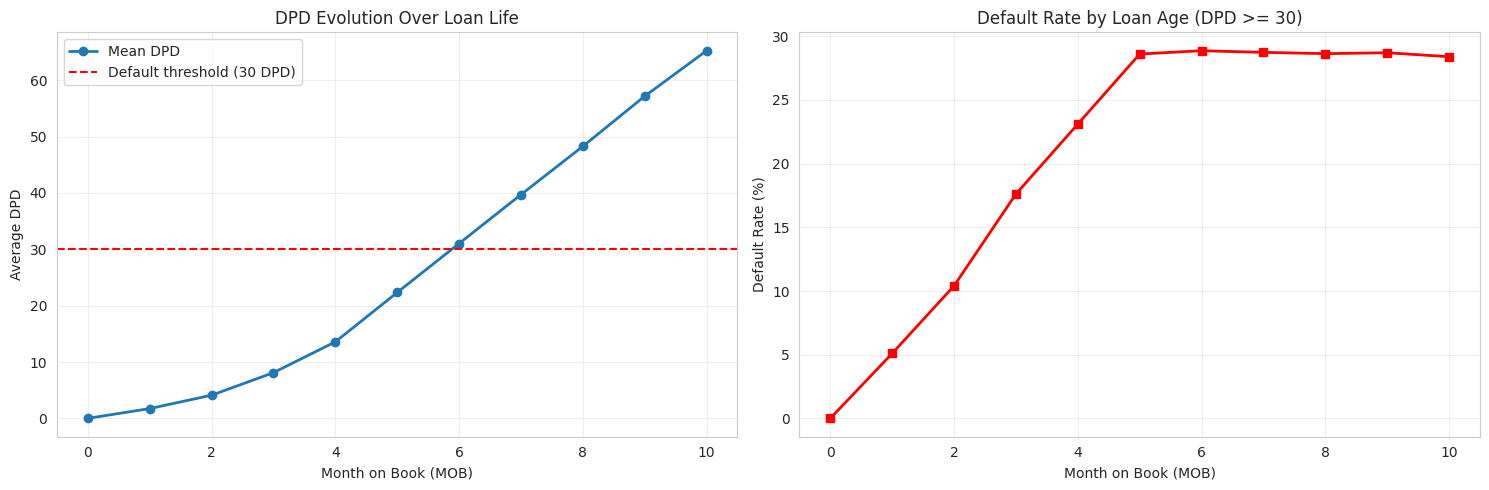

In [77]:
# Visualize default emergence
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(dpd_by_mob.index[:24], dpd_by_mob['mean_dpd'][:24], marker='o', label='Mean DPD', linewidth=2)
plt.axhline(y=30, color='red', linestyle='--', label='Default threshold (30 DPD)')
plt.xlabel('Month on Book (MOB)')
plt.ylabel('Average DPD')
plt.title('DPD Evolution Over Loan Life')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(dpd_by_mob.index[:24], dpd_by_mob['default_rate'][:24], marker='s', 
         color='red', linewidth=2)
plt.xlabel('Month on Book (MOB)')
plt.ylabel('Default Rate (%)')
plt.title('Default Rate by Loan Age (DPD >= 30)')
plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.savefig('default_progression.png', dpi=150, bbox_inches='tight')
plt.close()
print("\n✓ Saved: default_progression.png")

#### 💡 KEY INSIGHTS FOR FEATURE ENGINEERING:

1. TARGET DEFINITION:
   - Use DPD >= 30 after MOB >= 6 as default label
   - This gives loans time to mature before labeling

2. CAPACITY FEATURES:
   - DTI = Outstanding_Debt / Annual_Income
   - Loan_to_Income ratio
   - Log(Annual_Income) for scale normalization
   - Income bands for segmentation

3. CREDIT DEPTH:
   - Credit_History_Age (in years and months)
   - Number of active loans
   - Credit limit changes over time windows

4. DELINQUENCY HISTORY:
   - Count delayed payments in 3m, 6m, 12m windows
   - Ever had 30+ DPD flag
   - Time since last delay

5. BEHAVIORAL:
   - Payment behaviour (one-hot encode)
   - Credit Mix (Good/Standard/Bad)
   - Loan type diversity

6. DEMOGRAPHICS:
   - Age bands (18-25, 26-35, etc.)
   - Occupation categories

7. CLICKSTREAM:
   - Aggregate fe_1 to fe_20 over 7-day and 30-day windows
   - Sum, mean, std as activity metrics
   - Recency features

8. APPLICATION FEATURES:
   - EMI_to_Income ratio
   - Requested amount and tenure

## CORRELATION WITH DEFAULT - WHICH FEATURES MATTER MOST?

### Creating labeled sample for analysis

In [162]:
# Define default: loans with DPD >= 30 and MOB >= 6
labeled_loans = loan_df.filter(col("mob") >= 6) \
    .groupBy("loan_id", "Customer_ID") \
    .agg(F.max("dpd").alias("max_dpd")) \
    .withColumn("default_label", (col("max_dpd") >= 30).cast("int"))

# Join with first loan snapshot (application time)
loan_first_with_label = loan_first.join(labeled_loans, on="loan_id", how="inner")

# Join with financial features
labeled_df = loan_first_with_label.join(
    fin_latest.select("Customer_ID", "Annual_Income", "Outstanding_Debt", 
                     "Num_of_Delayed_Payment", "Credit_History_Age", 
                     "Num_of_Loan", "Credit_Mix"),
    on="Customer_ID",
    how="inner"
).join(
    attr_df.select("Customer_ID", "age_clean", "Occupation"),
    on="Customer_ID",
    how="inner"
)

labeled_sample = labeled_df.limit(20000).toPandas()

In [163]:
print(f"\nLabeled dataset size: {len(labeled_sample):,}")
print(f"Default rate: {labeled_sample['default_label'].mean()*100:.2f}%")


Labeled dataset size: 8,974
Default rate: 28.87%


In [164]:
# Calculate derived features
labeled_sample['DTI'] = labeled_sample['Outstanding_Debt'] / labeled_sample['Annual_Income']
labeled_sample['Loan_to_Income'] = labeled_sample['loan_amt'] / labeled_sample['Annual_Income']

### Correlation analysis

In [165]:
# Correlation analysis
print("\n--- Feature Correlation with Default ---")
numeric_features = ['loan_amt', 'tenure', 'Annual_Income', 'Outstanding_Debt', 
                   'DTI', 'Loan_to_Income', 'Num_of_Delayed_Payment', 
                   'Credit_History_Age_Years', 'Num_of_Loan', 'age_clean']

correlations = []
for feature in numeric_features:
    if feature in labeled_sample.columns:
        corr = labeled_sample[['default_label', feature]].corr().iloc[0, 1]
        correlations.append((feature, corr))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)

print("\nTop features correlated with default:")
for feature, corr in correlations:
    print(f"  {feature:30s}: {corr:+.4f}")


--- Feature Correlation with Default ---

Top features correlated with default:
  loan_amt                      : +nan
  tenure                        : +nan
  Outstanding_Debt              : +0.3116
  DTI                           : +0.2478
  Loan_to_Income                : +0.1619
  age_clean                     : -0.0888
  Annual_Income                 : -0.0116
  Num_of_Loan                   : +0.0064
  Num_of_Delayed_Payment        : -0.0028


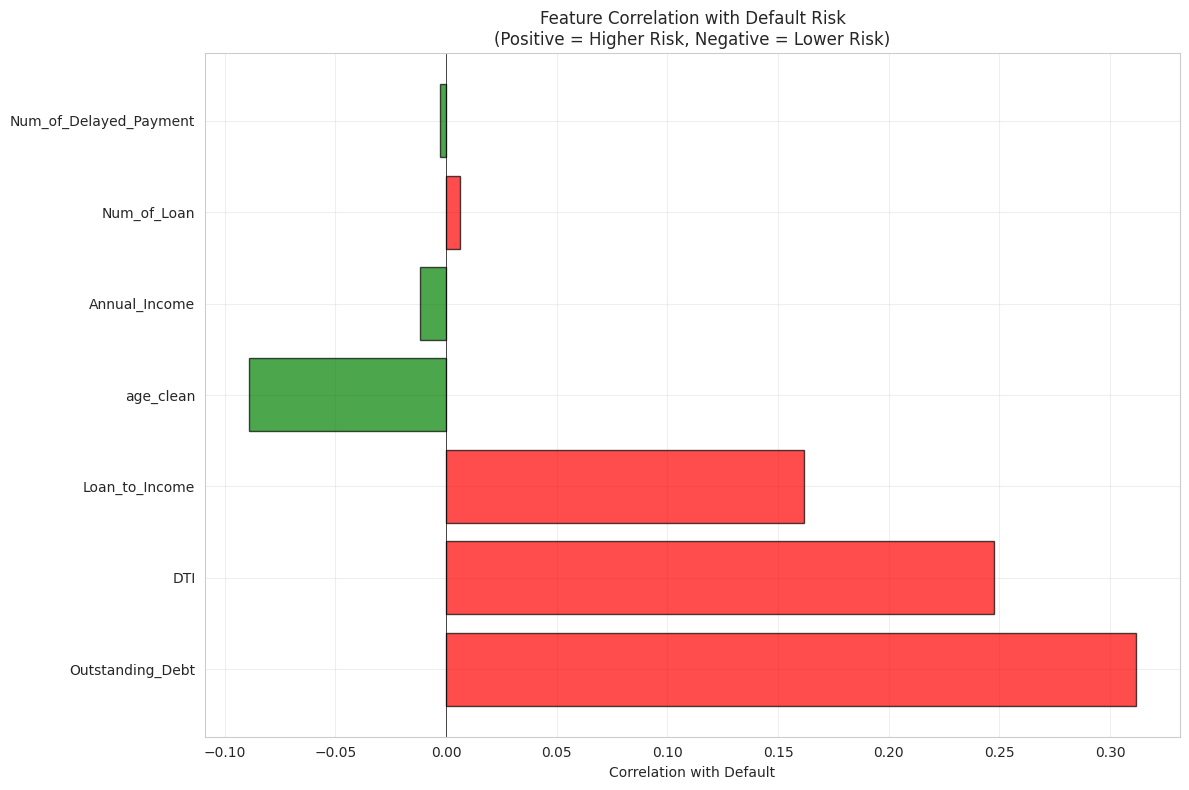

In [166]:
# Visualize feature importance
plt.figure(figsize=(12, 8))

features = [x[0] for x in correlations]
corr_values = [x[1] for x in correlations]
colors = ['red' if x > 0 else 'green' for x in corr_values]

plt.barh(features, corr_values, color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Correlation with Default')
plt.title('Feature Correlation with Default Risk\n(Positive = Higher Risk, Negative = Lower Risk)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
# plt.close()
# print("\n✓ Saved: feature_importance.png")

### Distribution comparison: Defaulters vs Non-defaulters

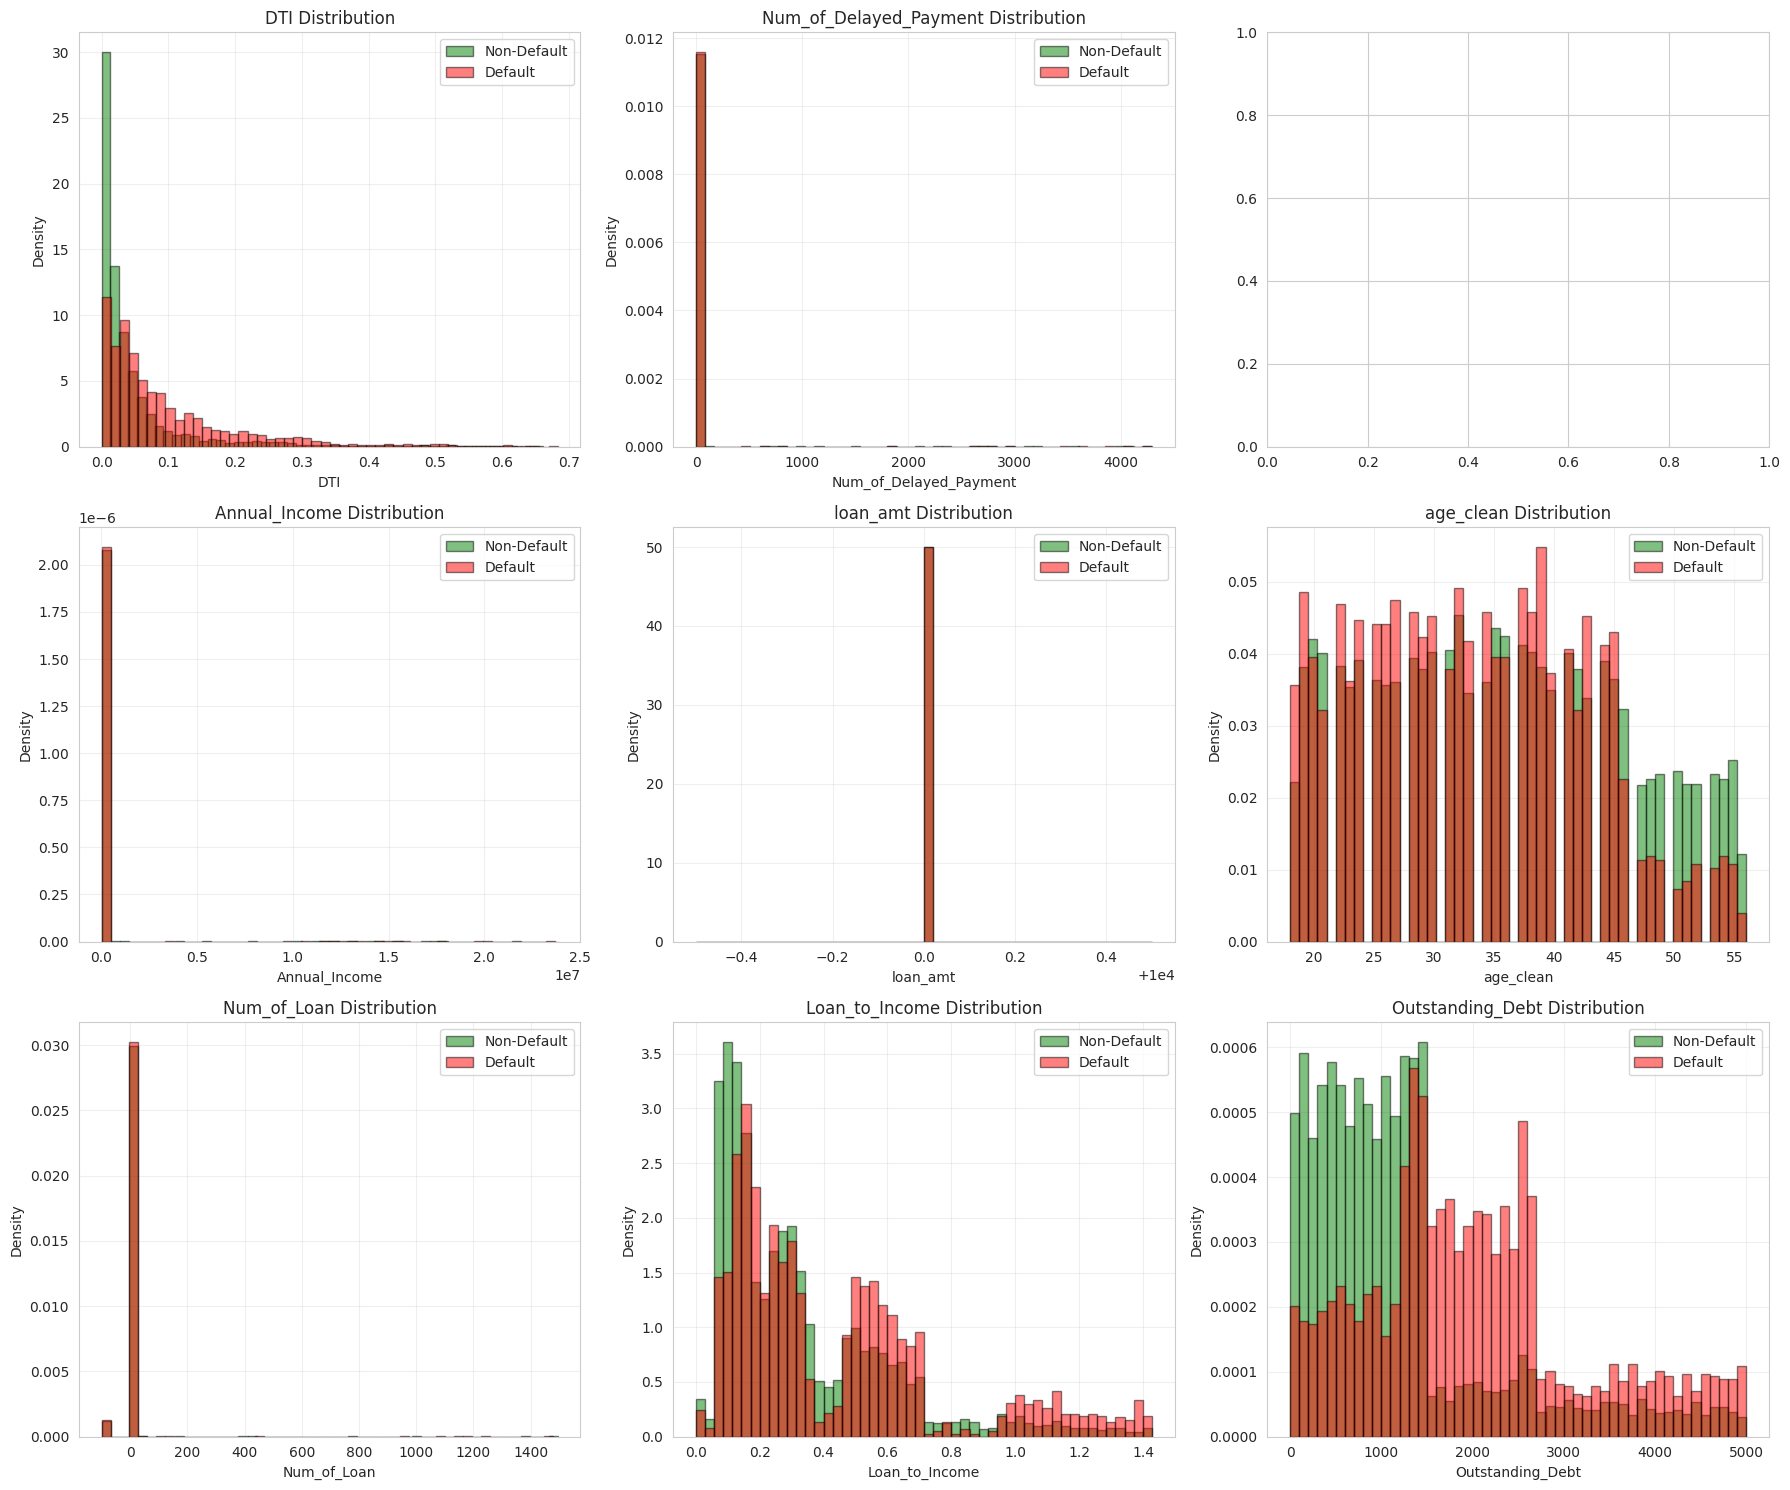

In [167]:
# Distribution comparison: Defaulters vs Non-defaulters
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

comparison_features = ['DTI', 'Num_of_Delayed_Payment', 'Credit_History_Years', 
                      'Annual_Income', 'loan_amt', 'age_clean', 'Num_of_Loan', 
                      'Loan_to_Income', 'Outstanding_Debt']

for idx, feature in enumerate(comparison_features):
    if feature in labeled_sample.columns:
        ax = axes[idx]
        
        non_default = labeled_sample[labeled_sample['default_label'] == 0][feature].dropna()
        default = labeled_sample[labeled_sample['default_label'] == 1][feature].dropna()
        
        # Handle outliers for better visualization
        if feature in ['DTI', 'Loan_to_Income']:
            non_default = non_default.clip(upper=2)
            default = default.clip(upper=2)
        
        ax.hist(non_default, bins=50, alpha=0.5, label='Non-Default', 
               color='green', edgecolor='black', density=True)
        ax.hist(default, bins=50, alpha=0.5, label='Default', 
               color='red', edgecolor='black', density=True)
        
        ax.set_xlabel(feature)
        ax.set_ylabel('Density')
        ax.set_title(f'{feature} Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('default_comparison.png', dpi=150, bbox_inches='tight')
# plt.close()
# print("✓ Saved: default_comparison.png")

### Categorical feature analysis

In [115]:
# Categorical feature analysis
print("\n--- Categorical Features and Default ---")

if 'Credit_Mix' in labeled_sample.columns:
    credit_mix_default = labeled_sample.groupby('Credit_Mix')['default_label'].agg(['mean', 'count'])
    credit_mix_default['default_rate'] = (credit_mix_default['mean'] * 100).round(2)
    print("\nCredit Mix Default Rates:")
    print(credit_mix_default)


--- Categorical Features and Default ---

Credit Mix Default Rates:
                mean  count  default_rate
Credit_Mix                               
Bad         0.560095   1689         56.01
Good        0.163312   2186         16.33
Standard    0.236653   3203         23.67
_           0.279536   1896         27.95


### Age group analysis

In [116]:
# Age group analysis
labeled_sample['age_group'] = pd.cut(labeled_sample['Age'], 
                                     bins=[0, 25, 35, 45, 55, 100],
                                     labels=['18-25', '26-35', '36-45', '46-55', '56+'])
age_default = labeled_sample.groupby('age_group')['default_label'].agg(['mean', 'count'])
age_default['default_rate'] = (age_default['mean'] * 100).round(2)
print("\nAge Group Default Rates:")
print(age_default)


Age Group Default Rates:
               mean  count  default_rate
age_group                               
18-25      0.327703   2368         32.77
26-35      0.306388   2536         30.64
36-45      0.304208   2495         30.42
46-55      0.160561   1283         16.06
56+        0.112903     62         11.29


/tmp/ipykernel_19270/3818471876.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_default = labeled_sample.groupby('age_group')['default_label'].agg(['mean', 'count'])


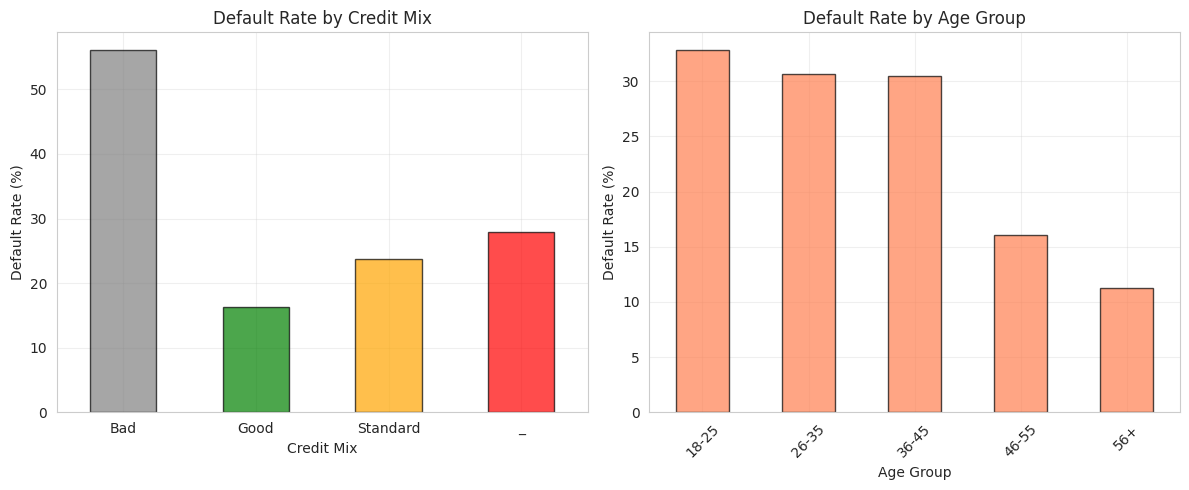

In [118]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
if 'Credit_Mix' in labeled_sample.columns:
    credit_mix_default['default_rate'].plot(kind='bar', color=['grey', 'green', 'orange', 'red'], 
                                            edgecolor='black', alpha=0.7)
    plt.xlabel('Credit Mix')
    plt.ylabel('Default Rate (%)')
    plt.title('Default Rate by Credit Mix')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
age_default['default_rate'].plot(kind='bar', color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Age Group')
plt.ylabel('Default Rate (%)')
plt.title('Default Rate by Age Group')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('categorical_default_analysis.png', dpi=150, bbox_inches='tight')
# plt.close()
# print("✓ Saved: categorical_default_analysis.png")

## FEATURE ENGINEERING RECOMMENDATIONS SUMMARY

In [119]:
print("\n📊 BASED ON EXPLORATION, CREATE THESE FEATURES:")
print("\n" + "─"*80)

print("\n🔹 CAPACITY/AFFORDABILITY (predict ability to pay):")
print("   ✓ DTI = Outstanding_Debt / Annual_Income")
print("   ✓ log_Annual_Income (normalize scale)")
print("   ✓ income_band (categorical: <20k, 20-50k, 50-100k, 100k+)")
print("   ✓ Loan_to_Income = loan_amt / Annual_Income")
print("   ✓ EMI_to_Income = estimated_monthly_payment / monthly_income")

print("\n🔹 CREDIT DEPTH (experience with credit):")
print("   ✓ Credit_History_Age_Year = Credit_History_Age / 12")
print("   ✓ Num_of_Loan_active (current number of loans)")
print("   ✓ Changed_Credit_Limit_sum_3m, _6m (credit limit volatility)")
print("   ✓ count_credit_limit_changes_3m, _6m")

print("\n🔹 DELINQUENCY HISTORY (past payment behavior):")
print("   ✓ Num_of_Delayed_Payment_3m, _6m, _12m (time windows)")
print("   ✓ ever_30dpd_prior (binary flag)")
print("   ✓ max_dpd_prior (capped at 180)")
print("   ✓ time_since_last_delay (recency)")

print("\n🔹 BEHAVIORAL PATTERNS (spending & credit habits):")
print("   ✓ Payment_Behaviour one-hot encoding")
print("   ✓ Credit_Mix one-hot encoding (Good/Standard/Bad)")
print("   ✓ Type_of_Loan multi-hot flags")
print("   ✓ loan_type_count (diversity)")

print("\n🔹 DEMOGRAPHICS (basic customer info):")
print("   ✓ Age (raw)")
print("   ✓ age_band (18-25, 26-35, 36-45, 46-55, 56+)")
print("   ✓ Occupation one-hot encoding (top categories)")

print("\n🔹 CLICKSTREAM (user engagement):")
print("   ✓ fe_1 to fe_20: sum_7d, mean_7d (recent activity)")
print("   ✓ fe_1 to fe_20: sum_30d, mean_30d, std_30d (activity patterns)")
print("   ✓ total_activity trends")

print("\n🔹 APPLICATION CONTEXT (loan request details):")
print("   ✓ requested_amount = loan_amt")
print("   ✓ requested_tenure")
print("   ✓ estimated_EMI (calculated from amount & tenure)")

print("\n🔹 TARGET LABEL:")
print("   ✓ default_label = 1 if (DPD >= 30) AND (MOB >= 6), else 0")
print("   ✓ This gives loans 6 months to mature before labeling")

print("\n" + "─"*80)
print("\n⚠️  CRITICAL: TEMPORAL POINT-IN-TIME CORRECTNESS")
print("   - All features MUST be computed using data where snapshot_date <= application_date")
print("   - NO peeking into the future!")
print("   - Join tables with date filters to ensure no data leakage")

print("\n" + "─"*80)
print("\n📈 STRONGEST PREDICTORS (from correlation analysis):")
for feature, corr in correlations[:5]:
    direction = "↑ Higher risk" if corr > 0 else "↓ Lower risk"
    print(f"   {feature:30s}: {corr:+.4f}  {direction}")


9. FEATURE ENGINEERING RECOMMENDATIONS SUMMARY

📊 BASED ON EXPLORATION, CREATE THESE FEATURES:

────────────────────────────────────────────────────────────────────────────────

🔹 CAPACITY/AFFORDABILITY (predict ability to pay):
   ✓ DTI = Outstanding_Debt / Annual_Income
   ✓ log_Annual_Income (normalize scale)
   ✓ income_band (categorical: <20k, 20-50k, 50-100k, 100k+)
   ✓ Loan_to_Income = loan_amt / Annual_Income
   ✓ EMI_to_Income = estimated_monthly_payment / monthly_income

🔹 CREDIT DEPTH (experience with credit):
   ✓ Credit_History_Age_Year = Credit_History_Age / 12
   ✓ Num_of_Loan_active (current number of loans)
   ✓ Changed_Credit_Limit_sum_3m, _6m (credit limit volatility)
   ✓ count_credit_limit_changes_3m, _6m

🔹 DELINQUENCY HISTORY (past payment behavior):
   ✓ Num_of_Delayed_Payment_3m, _6m, _12m (time windows)
   ✓ ever_30dpd_prior (binary flag)
   ✓ max_dpd_prior (capped at 180)
   ✓ time_since_last_delay (recency)

🔹 BEHAVIORAL PATTERNS (spending & credit habits)

In [168]:
# Cleanup
spark.stop()
print("\n✓ Spark session stopped")
print("\n" + "="*80)


✓ Spark session stopped

